In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as sk_model_selection
import statsmodels.tsa.seasonal as statsmodels_seasonal
import TSErrors

%matplotlib inline

In [13]:
def make_cv_splits(data_df, n_splits):
    time_series_cv_splits = sk_model_selection.TimeSeriesSplit(n_splits=n_splits)
    data_cv_indexes = time_series_cv_splits.split(data_df)

    data_cv_splits = []
    for train_indexes, test_indexes in data_cv_indexes:
        train, test = data_df.iloc[train_indexes], data_df.iloc[test_indexes]
        data_cv_splits.append((train, test))
    data_cv_splits.pop(0)
    return data_cv_splits
    

def create_data_frame(values, last_date):
    dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=len(values), freq="MS")
    predicted_df = pd.DataFrame({"value": values}, index=dates)
    return predicted_df


def naive_prediction(train_df, observation_to_predict):
    values = [train_df.iat[-1, 0] for i in range(observation_to_predict)]
    return create_data_frame(values, train_df.index[-1])


def average_prediction(train_df, observation_to_predict):
    mean = train_df["value"].mean()
    values = [mean for i in range(observation_to_predict)]
    return create_data_frame(values, train_df.index[-1])


def make_cv_prediction(cv_splits, model):
    predictions = []
    for train_df, test_df in cv_splits:
        prediction_df = model(train_df, len(test_df))
        predictions.append(prediction_df)
    return pd.concat(predictions)


def calculate_errors(true_df, predicted_df, metrics=("mae", "rmse", "mape")):
    ts_errros = TSErrors.FindErrors(true_df, predicted_df)
    all_errors = ts_errros.calculate_all()
    error_list = {key: all_errors[key] for key in metrics}
    return error_list

In [14]:
utility_index_df = pd.read_csv("data/IPG2211A2N.csv", parse_dates=["DATE"])
utility_index_df.rename(columns={"DATE":"date", "IPG2211A2N": "value"}, inplace=True)
utility_index_df.set_index("date", inplace=True)

utility_index_df = utility_index_df[
    (utility_index_df.index >= pd.Timestamp("1980-01-01")) &
    (utility_index_df.index < pd.Timestamp("2020-12-01"))
]

In [15]:
number_of_splits = 6
utility_index_cv_splits = make_cv_splits(utility_index_df, number_of_splits)

test_data = pd.concat([t for (_, t) in utility_index_cv_splits])

naive_predictions = make_cv_prediction(utility_index_cv_splits, naive_prediction)
naive_errors = calculate_errors(test_data, naive_predictions)
print("Naive errors: ", naive_errors)

average_predictions = make_cv_prediction(utility_index_cv_splits, average_prediction)
average_errors = calculate_errors(test_data, average_predictions)
print("Average errors: ", average_errors)

Naive errors:  {'mae': 10.930260285714287, 'rmse': 13.714539356850452, 'mape': 11.220767492208552}
Average errors:  {'mae': 20.634260999153852, 'rmse': 22.631973483061156, 'mape': 21.02094002197741}


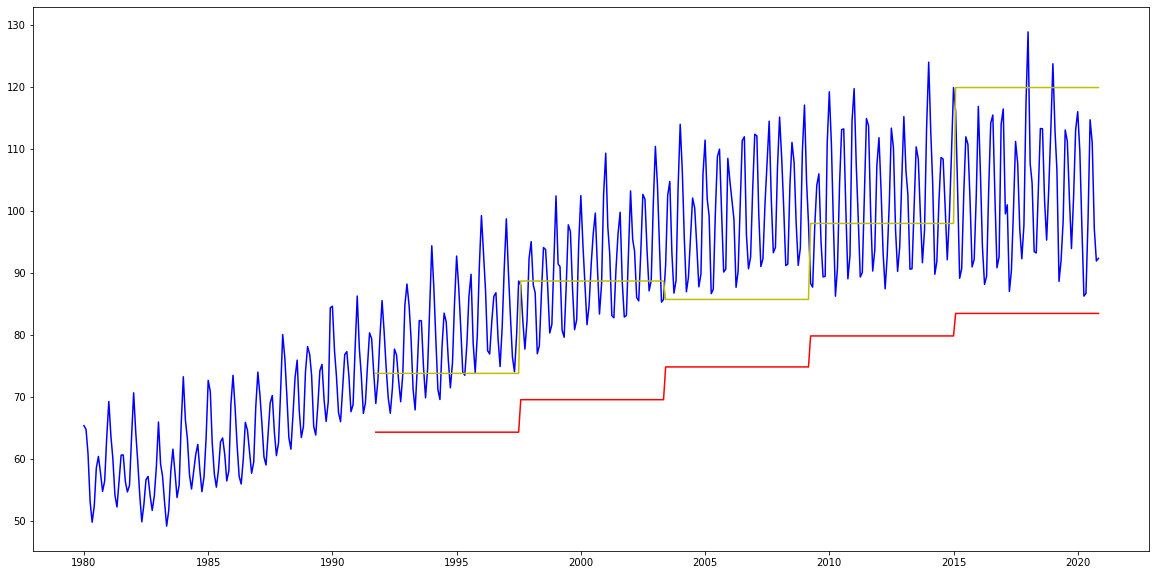

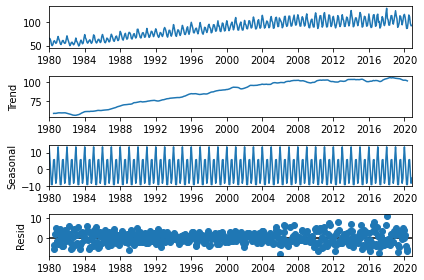

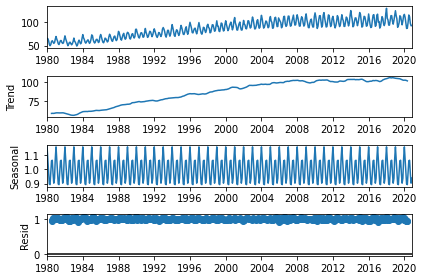

In [16]:
plt.figure(figsize=(20, 10))

plt.plot(utility_index_df.index, utility_index_df["value"], color="b")
plt.plot(naive_predictions.index, naive_predictions["value"], color="y")
plt.plot(naive_predictions.index, average_predictions["value"], color="r")

utility_index_additive_decomposition = statsmodels_seasonal.seasonal_decompose(
    utility_index_df, model="additive")
utility_index_multiplicative_decomposition = statsmodels_seasonal.seasonal_decompose(
    utility_index_df, model="multiplicative")

utility_index_additive_decomposition.plot()
utility_index_multiplicative_decomposition.plot()

plt.show()